In [1]:
# import library 
# ========= choice of library ====
import tensorflow as tf
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from scipy.misc import imread,imresize
from imgaug import augmenters as iaa
import nibabel as nib
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

# Generate training data
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data
# ========= choice of library ====

In [2]:
# input the mnist data
mnist = input_data.read_data_sets('../../Dataset/MNIST/', one_hot=True)
x_data, train_label, y_data, test_label = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
x_data_added,x_data_added_label = mnist.validation.images,mnist.validation.labels
x_data = x_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
y_data = y_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
x_data_added = x_data_added.reshape(-1, 28, 28, 1)
x_data = np.vstack((x_data,x_data_added))
train_label = np.vstack((train_label,x_data_added_label))

train_batch = np.zeros((60000,28,28,1))
test_batch = np.zeros((10000,28,28,1))

for x in range(len(x_data)):
    train_batch[x,:,:,:] = np.expand_dims(imresize(x_data[x,:,:,0],(28,28)),axis=3)
for x in range(len(y_data)):
    test_batch[x,:,:,:] = np.expand_dims(imresize(y_data[x,:,:,0],(28,28)),axis=3)

# print out the data shape and the max and min value
print(train_batch.shape)
print(train_batch.max())
print(train_batch.min())
print(train_label.shape)
print(train_label.max())
print(train_label.min())
print(test_batch.shape)
print(test_batch.max())
print(test_batch.min())
print(test_label.shape)
print(test_label.max())
print(test_label.min())

Extracting ../../Dataset/MNIST/train-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-labels-idx1-ubyte.gz


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


(60000, 28, 28, 1)
255.0
0.0
(60000, 10)
1.0
0.0
(10000, 28, 28, 1)
255.0
0.0
(10000, 10)
1.0
0.0


(100, 28, 28, 1)


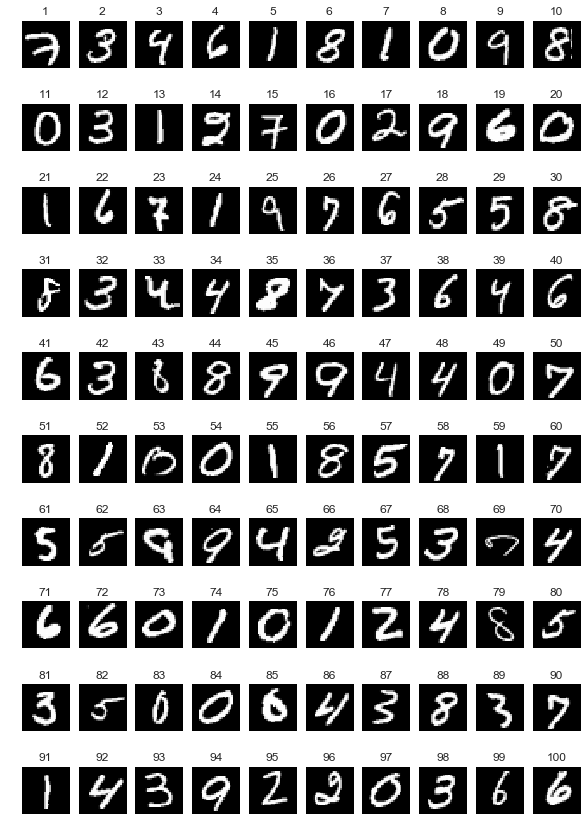

In [3]:
# divide the train data and show
train_small = train_batch[:100,:,:,:]
print(train_small.shape)
fig=plt.figure(figsize=(10, 15))
columns = 10 ; rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(train_small[i-1]),cmap='gray')
    plt.axis('off')
    plt.title(str(i))
plt.show()

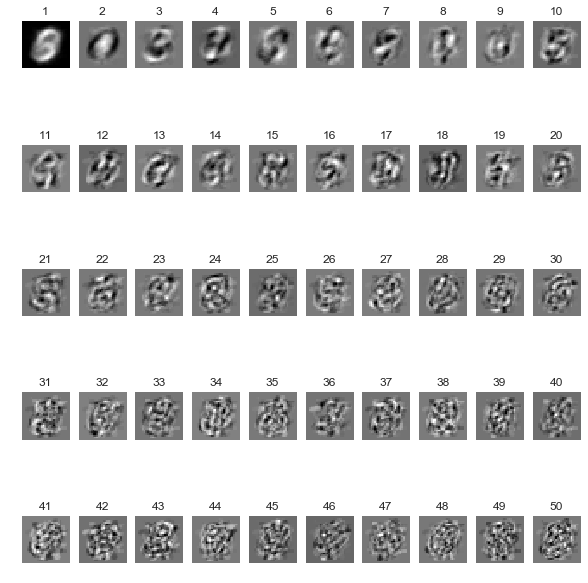

In [4]:
# use the sklearn pca
from sklearn.decomposition import PCA
sk_pca = PCA(n_components=50)
sk_pca_data = sk_pca.fit_transform(train_small.reshape(100,-1).T).T
sk_pca_data = sk_pca_data.reshape(50,28,28)
fig=plt.figure(figsize=(10, 11))
columns = 10 ; rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(sk_pca_data[i-1],cmap='gray')
    plt.axis('off')
    plt.title(str(i))
plt.show()

(100, 784)
(100, 100)
(100,)
(100, 100)
(100, 50)
(50, 784)


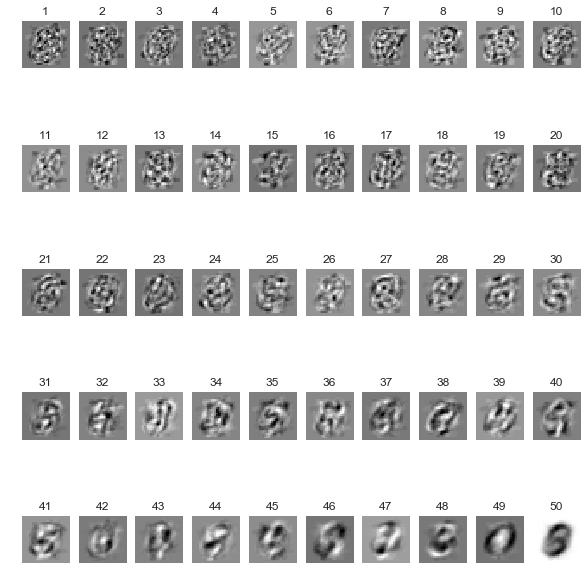

In [5]:
# do the manual pca
train_reshape = train_small.reshape(100,-1)
train_mean = train_reshape - train_reshape.mean(1)[:,np.newaxis]
print(train_mean.shape)
train_cov = (train_mean.dot(train_mean.T))/train_mean.shape[0]
print(train_cov.shape)
from scipy.linalg import eigh
eigval,eigvec = eigh(train_cov)
print(eigval.shape)
print(eigvec.shape)
trans = eigvec[:,-50:]
print(trans.shape)
final_trans = trans.T.dot(train_reshape)
# final_trans = (final_trans-final_trans.min())/(final_trans.max()-final_trans.min())
print(final_trans.shape)
final_reshape = final_trans.reshape(50,28,28)
fig=plt.figure(figsize=(10, 11))
columns = 10 ; rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(final_reshape[i-1],cmap='gray')
    plt.axis('off')
    plt.title(str(i))
plt.show()

beta1,beta2,adam_e = 0.9,0.999,1e-8

In [192]:
# layer
class tf_pca_layer():
    
    def __init__(self,n_components):
        self.n_components = tf.Variable(n_components)
    
    def feedforward(self,input):
        self.input = input
        self.cov = tf.matmul(self.input,tf.transpose(self.input)) / (input.shape[0].value-1)
        self.eigval,self.pc = tf.linalg.eigh(self.cov)
        self.pc_projection = self.pc[:,-self.n_components:]
        self.layer = tf.matmul(tf.transpose(self.pc_projection),input)
        return self.layer
    
    def backprop(self,grad):
        mat_shape = self.input.shape[0].value
        d_pc_project = tf.transpose(tf.matmul(grad,tf.transpose(self.input)))
        diff = mat_shape - self.n_components
        added_mat = tf.zeros([mat_shape,diff],dtype=tf.float64)
        d_pc = tf.concat([d_pc_project,added_mat],1)
        
        E = tf.matmul(tf.ones([mat_shape,1],dtype=tf.float64),tf.transpose(self.eigval)[tf.newaxis,:]) - \
            tf.matmul(self.eigval[:,tf.newaxis],tf.ones([1,mat_shape],dtype=tf.float64))
        F = 1.0/(E + tf.eye(mat_shape,dtype=tf.float64)) - tf.eye(mat_shape,dtype=tf.float64)
        d_cov = tf.matmul(tf.linalg.inv(tf.transpose(self.pc)),
                tf.matmul(F * (tf.matmul(tf.transpose(self.pc),d_pc)),tf.transpose(self.pc)))
        
        d_x = tf.matmul(self.pc_projection,grad) + \
              (tf.matmul(d_cov,self.input) + tf.matmul(tf.transpose(d_cov),self.input))/(mat_shape-1)
        
        return d_x

def tf_logcosh(x): return tf.log(tf.cosh(x))
def d_tf_logcosh(x): return tf.tanh(x)
def tf_tanh(x): return tf.tanh(x)
def d_tf_tanh(x): return 1.0 - tf_tanh(x) ** 2
def tf_sigmoid(x): return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))
# ======= Activation Function  ==========

class FastICA_Layer():
    """Performs ICA via FastICA method

    Parameters
    ----------
    inc : type
        Description of parameter `inc`.
    outc : type
        Description of parameter `outc`.
    act : type
        Description of parameter `act`.
    d_act : type
        Description of parameter `d_act`.

    Attributes
    ----------
    w : type
        Description of attribute `w`.
    sym_decorrelation : type
        Description of attribute `sym_decorrelation`.
    m : type
        Description of attribute `m`.
    v : type
        Description of attribute `v`.
    self,matrix : type
        Description of attribute `self,matrix`.
    act
    d_act

    """

    def __init__(self,inc,outc,act,d_act):
        self.w = tf.Variable(self.sym_decorrelation(tf.random_normal(shape=[inc,outc],stddev=0.05,dtype=tf.float64,seed=2)))
        self.m = tf.Variable(tf.zeros_like(self.w)) ; self.v = tf.Variable(tf.zeros_like(self.w))
        self.act = act; self.d_act = d_act

    def sym_decorrelation(self,matrix):
        s, u = tf.linalg.eigh(tf.matmul(matrix,tf.transpose(matrix)))
        decor_matrx = tf.matmul(u * (1.0/tf.sqrt(s)),tf.transpose(u))
        return tf.matmul(decor_matrx,matrix)

    def getw(self): return self.w

    def feedforward(self,input):
        self.input = input
        self.layer = tf.matmul(self.w,input)
        return self.layer

    def backprop_ica(self):
        self.layerA  = self.act(tf.matmul(self.w,self.input))
        self.layerDA = tf.reduce_mean(self.d_act(tf.matmul(self.w,self.input)),-1)
        grad_pass = tf.matmul(tf.transpose(self.w),self.layerA)
        
        grad_w = tf.matmul(self.layerA,tf.transpose(self.input)) / self.input.shape[1].value - self.layerDA[:,tf.newaxis] * self.w
        grad = self.sym_decorrelation(grad_w)
        
        update_w = []
        
        # ==== Correct Method of Weight Update ====
#         update_w.append(tf.assign(self.w,grad))
        
        # ==== Wrong (gradient ascent) Method of Weight Update ====
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = m_hat *  learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle )))
        
        return grad_pass,update_w


In [234]:
# sess = tf.InteractiveSession()
learning_rate = 0.001
pca_l = tf_pca_layer(10)
ica_l = FastICA_Layer(5,10,act=tf_tanh,d_act=d_tf_tanh)

x = tf.placeholder(shape=[100,784],dtype=tf.float64)
pca_layer = pca_l.feedforward(x)
ica_layer = ica_l.feedforward(pca_layer)

grad_ica,grad_ica_up = ica_l.backprop_ica()
grad_pca = pca_l.backprop(grad_ica)
print(train_batch.shape)
train_batch_1 = train_batch[:1000,:,:,:]

(60000, 28, 28, 1)


In [235]:
sess.run(tf.global_variables_initializer())
for iter in range(300):
    train_batch_1 = shuffle(train_batch_1)
    for current_batch_index in range(0,len(train_batch_1),100):
        current_data = train_batch_1[current_batch_index:current_batch_index+100,:,:,:]
        current_data = current_data.reshape(100,-1)
        sess_results = sess.run([ica_layer,grad_ica_up],feed_dict={x:current_data})
        print(iter,sess_results[0].mean())

0 63.847681971315275
0 65.44490080071581
0 64.84214563202747
0 63.39716746958362
0 61.51692824765701
0 53.73601663070013
0 56.80288270875356
0 52.371279354096565
0 -53.898270705555724
0 55.34160710609998
1 52.81770398491055
1 50.48686304165646
1 60.132876043933294
1 58.149464932993034
1 50.80232649232653
1 47.57199896683951
1 49.53545082980107
1 59.32549774246314
1 49.3709805464742
1 49.04248606123934
2 42.36888535652564
2 51.88772300802397
2 58.67611117203116
2 48.173777919018725
2 62.2366757538832
2 49.944582441716264
2 45.180520061847204
2 50.04168477750556
2 51.715350862818305
2 48.09735793762333
3 44.500847607112284
3 48.2085739508521
3 41.53126412819506
3 42.05943971597068
3 36.764028682777514
3 49.35850377117299
3 35.73234527284742
3 47.094729672595214
3 48.60447222632947
3 38.503612130054094
4 45.26975056435071
4 37.80584283505203
4 42.38862961311033
4 39.226716549521406
4 43.015592201904155
4 37.576648873348475
4 42.76259384226379
4 48.62391810638529
4 49.25626784140116
4 42.3

39 7.834212116192455
39 7.3326564563077765
39 7.7490483450090695
39 8.43283441750979
39 5.131719687712931
39 6.843808501770052
39 6.5417441433926875
39 7.747437619614539
39 -7.202170626660037
39 5.63446964699664
40 9.241507998319358
40 6.326881252043159
40 6.324360802600262
40 8.836531820105135
40 6.271192544990216
40 6.883925098935656
40 7.880664276176526
40 4.703008347751975
40 6.685738330569312
40 3.9864389622723935
41 4.411459065069011
41 5.974341112900771
41 2.9009922583363723
41 5.6591567058725945
41 4.863577417395118
41 7.363318235015905
41 6.499997695331011
41 9.528851744847133
41 2.4510695781258516
41 7.125324990408163
42 8.571693440489026
42 6.777640875759657
42 9.329857497904431
42 5.226300194309368
42 4.496621878452854
42 4.677532054236548
42 3.9982218486964483
42 7.459948595908599
42 -4.833292881854632
42 5.04362582299323
43 6.039644107941426
43 4.484192710523355
43 5.034881935793154
43 4.394161850311508
43 4.161549504963227
43 5.370943879339783
43 3.802739115491858
43 3.5

76 0.12625173815955495
76 -0.20749730384808515
76 0.013790972690674065
76 -0.10393307388969865
76 -0.5983044404622025
76 0.3411071016093781
76 -0.32662796970659036
76 0.16891316634927245
76 -0.6203436534191737
76 -0.12420946221194289
77 0.181610612521411
77 -0.32534445396797895
77 0.24457069697302689
77 0.06700881624611142
77 -0.30569129433676717
77 -0.28391494675857537
77 0.37216492187295974
77 0.30096259503931233
77 0.21400741475840854
77 0.1862793957093379
78 0.27216595384515946
78 0.0092396372520533
78 0.41320112057665803
78 -0.33791656162895994
78 0.4808067192168698
78 -0.36535015522309916
78 0.5160152912656006
78 -0.0038247347542923996
78 -0.6154198484840793
78 0.2928697981533601
79 -0.15664466526206422
79 -0.295393776544658
79 -0.033425026653765365
79 -0.04339737858691041
79 0.02530764620119086
79 -0.23740136736791137
79 0.4256924536851516
79 0.4685390215526289
79 -0.24294899730395836
79 -0.011044038384055552
80 0.6172350031299353
80 -0.44460316894449786
80 -0.7076970252706956
8

109 0.0037052584734062954
109 -0.0015727298381751054
109 -0.004808746619568766
110 0.00023528128775985165
110 0.0031993071512751614
110 0.00046856845034027033
110 -0.004543205009473423
110 0.00516035110081344
110 0.006042500663299367
110 0.0009284836730854204
110 -0.008634512933302465
110 -0.007466109694488018
110 0.0014427848529017261
111 0.008314243245743046
111 0.00720585944548656
111 0.0036673428763818565
111 -0.00970398872596804
111 -0.008987523093071008
111 -0.002845874217422992
111 0.00674231503125921
111 0.003969727121782045
111 -0.003449595292943965
111 -0.0071743635793897744
112 -1.3425451347898754e-05
112 0.007326637254281273
112 0.0028741375758076174
112 -0.004896533985347177
112 -0.005468597824955792
112 -0.00027853139824732877
112 0.004964871333751658
112 0.0033067381917389073
112 -0.004225355191699497
112 0.0003180862259549989
113 0.0036208203853159582
113 0.002357797440792878
113 -0.00018721347680001298
113 -0.002801406786168773
113 0.0033879738782151797
113 0.004087822

141 -0.0021247423308097136
141 3.898312728308558e-05
141 0.0006395558534564719
141 -0.001753030338721916
141 -0.0010973977233457374
141 0.0012647126946377847
141 0.0026002224008527942
142 -5.728461948003877e-05
142 -0.002918110509442248
142 -0.0022103411664396223
142 0.0024421421379968063
142 0.003120590322410686
142 -0.0007986869777904644
142 -0.0034014040548408057
142 -0.0012701187944149052
142 0.005569819977412788
142 0.007858980553123495
143 0.0039838965651530205
143 -0.0064312158667355615
143 -0.011116230590947256
143 -0.008288099224953051
143 -1.2804557979117832e-05
143 0.006052031846278024
143 0.005473133636775908
143 -0.0010312260810695982
143 -0.0035534733541391725
143 -0.003426570144366625
144 -0.0011431329608693243
144 0.003326593675160183
144 0.004416052714853008
144 0.0018207135970548076
144 -0.0011874741353035895
144 -0.0054921614436834396
144 -0.004415439281931266
144 0.0015596587100640867
144 0.0029247402671985934
144 0.0025905441844388914
145 -0.0012890071196493347
145

172 0.005337751572709571
173 -0.0012942714574797854
173 -0.006568288871328732
173 -0.004538749396454598
173 0.00036166870425244027
173 0.004611942531133094
173 0.004942977858231144
173 0.0007951336760570868
173 -0.004485259400385718
173 -0.0010106998630307067
173 0.004189086731629179
174 0.002005548356339238
174 -0.0010923283051797038
174 -0.0021497889490062405
174 -0.00032671610290965325
174 0.0034591596849040734
174 0.0015753530205718084
174 -0.0018567720615985763
174 -0.0031882362008652247
174 -0.0021094705790801536
174 0.004142343777494698
175 0.005433814508197991
175 0.003779677930324221
175 -0.00924900489105929
175 -0.014555926051326117
175 -0.009920408051048223
175 0.003531708444124648
175 0.009945191624087656
175 0.005075339794182421
175 -0.00286282504713659
175 -0.0032422164658432923
176 0.0008780052564263238
176 0.001110583744745287
176 -0.0007056734739923611
176 0.00020352011092657031
176 0.0030550869392810187
176 0.003532459000908372
176 0.0019153905327229713
176 -0.0027338

205 0.008360061209569765
205 0.002127738269203657
205 -0.004270382368843926
205 -0.008522810524503254
205 -0.00862201786077204
205 -0.0047690124477217
205 0.004446564131818569
205 0.010388101254149839
205 0.008079250732656163
205 0.0024622933533497726
206 -0.006205087790616998
206 -0.007948438180651479
206 -0.006244694651984227
206 0.0028622102065285608
206 0.004626863436440081
206 0.008593759875111993
206 0.007686124839678361
206 0.004604259678702538
206 -0.004145983176082091
206 -0.008821336804762723
207 -0.008921719651578864
207 -0.0037040026265171655
207 0.006828582811499941
207 0.009024140349431104
207 0.008020364356161415
207 0.0004074548396507898
207 -0.004520938514840385
207 -0.004840727007107104
207 -0.0031058176363092864
207 -0.0026838217191783465
208 0.005454516191040904
208 0.007788894862010871
208 0.0060420415707772
208 2.958681696651534e-05
208 -0.004220141319815556
208 -0.00500291484464562
208 -0.004851888250374894
208 0.0004401030101941882
208 0.007428206360427957
208 0

236 0.0025798126650933184
236 -0.0013153107428715376
237 -0.0032830768560647232
237 0.001366934722197724
237 0.0035758610832767232
237 -0.0001917233564395186
237 -0.003715553367023894
237 0.002220181614990968
237 0.004667947930971796
237 -0.00299844070147273
237 -0.0012823153076991338
237 0.0025587915698450266
238 0.0011764354777499808
238 -0.002662408239480046
238 -0.0038248468124249023
238 0.0026120117646155545
238 -0.002911284028457874
238 -0.000835242091522999
238 -0.0027027184073388304
238 -0.0017268712243604675
238 0.0021547593364931493
238 0.00028866215623657773
239 -0.002464693555495689
239 0.002761988060548672
239 0.0010650233919989466
239 -0.006374710832570229
239 -0.006314977606499827
239 0.0019483995181908509
239 0.0006267738243963844
239 -0.0006392803471674854
239 -0.0022820290825603783
239 0.002476195735947095
240 0.0038734069567927486
240 0.0024269157745732133
240 -0.0001464231648083634
240 -0.002063939401672453
240 -0.0016666512141950377
240 -0.0008261642508781561
240 0

268 0.002311839682717134
268 -0.0015738424639894569
268 -0.003911522316905539
268 0.002912468747442268
268 0.006535870231687294
268 0.0035860949600592367
269 -0.008408109690534026
269 -0.008307909894202402
269 -0.0016366105259425351
269 0.006654728280306156
269 0.008343971907773707
269 0.0051609581177896775
269 -0.0027925368354191583
269 -0.006011918079104311
269 -0.004021192584006248
269 0.0038703149020842473
270 0.004347891870610226
270 -0.00044540265691791006
270 -0.006373315204870887
270 -0.0038966857042631834
270 0.0012772790356685554
270 0.0026424941336780396
270 0.0034249132402020418
270 0.0028443144036587884
270 -0.0007786231516173697
270 -0.003690730305623817
271 -0.0035063991175444988
271 0.00020322089418862223
271 0.0052397392658968655
271 0.004004866330060831
271 -0.0007742802917812616
271 -0.005544181823732746
271 -0.003965560604512994
271 0.003272980420437865
271 0.0023610024278525234
271 0.0001520218617724114
272 -0.0028172468740446164
272 -0.0017174640892335846
272 -0.0

299 9.803023311968974e-05


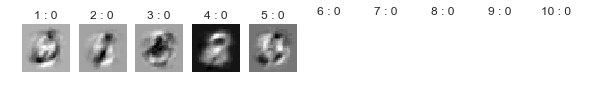

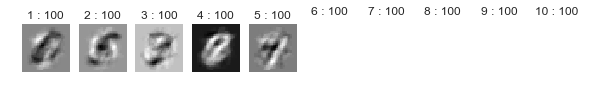

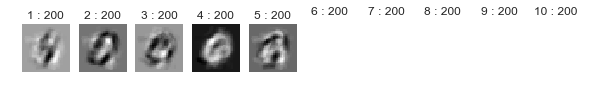

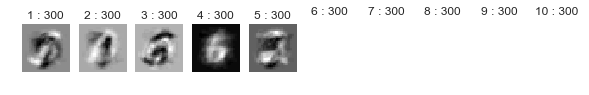

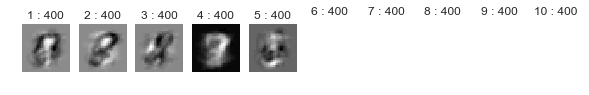

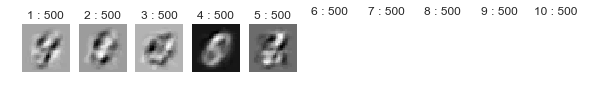

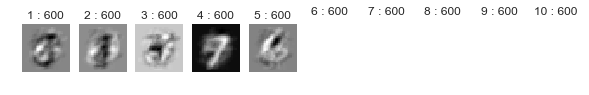

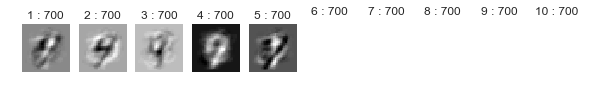

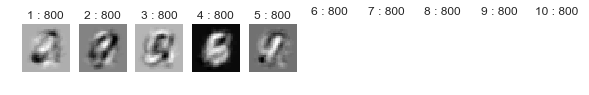

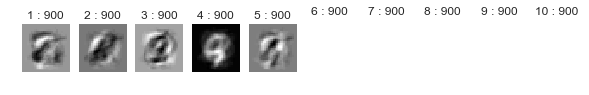

In [236]:
# show all
for current_batch_index in range(0,len(train_batch_1),100):
    current_data = train_batch_1[current_batch_index:current_batch_index+100,:,:,:]
    current_data = current_data.reshape(100,-1)
    final_reshape = sess.run(ica_layer,feed_dict={x:current_data})
    final_reshape = (final_reshape-final_reshape.min())/(final_reshape.max()-final_reshape.min()) 
    final_reshape = final_reshape.reshape(final_reshape.shape[0],28,28)
    fig=plt.figure(figsize=(10, 1))
    columns = 10 ; rows = 1
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        try:
            plt.imshow(final_reshape[i-1],cmap='gray')
        except:
            pass
        plt.axis('off')
        plt.title(str(i) + ' : ' + str(current_batch_index))
    plt.show()

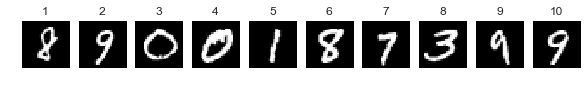

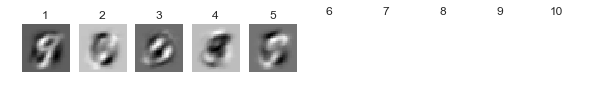

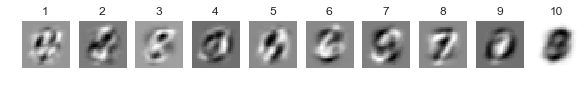

In [231]:
# two
current_data = train_batch_1[200:700,:,:,:].reshape(500,-1)
fig=plt.figure(figsize=(10, 1))
columns = 10 ; rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    try:
        plt.imshow(current_data[i-1].reshape(28,28),cmap='gray')
    except:
        pass
    plt.axis('off')
    plt.title(str(i))
plt.show()

final_reshape = sess.run(ica_layer,feed_dict={x:current_data})
final_reshape = (final_reshape-final_reshape.min())/(final_reshape.max()-final_reshape.min()) 
final_reshape = final_reshape.reshape(final_reshape.shape[0],28,28)
fig=plt.figure(figsize=(10, 1))
columns = 10 ; rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    try:
        plt.imshow(final_reshape[i-1],cmap='gray')
    except:
        pass
    plt.axis('off')
    plt.title(str(i))
plt.show()

final_reshape = sess.run(pca_layer,feed_dict={x:current_data})
final_reshape = (final_reshape-final_reshape.min())/(final_reshape.max()-final_reshape.min()) 
final_reshape = final_reshape.reshape(final_reshape.shape[0],28,28)
fig=plt.figure(figsize=(10, 1))
columns = 10 ; rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    try:
        plt.imshow(final_reshape[i-1],cmap='gray')
    except:
        pass
    plt.axis('off')
    plt.title(str(i))
plt.show()

In [237]:
! git all-go

[master e605e1c8] s
 4 files changed, 6318 insertions(+)
 create mode 100644 Understanding_Concepts/review_ICA_PCA/.ipynb_checkpoints/z back to basics-checkpoint.ipynb
 rename Understanding_Concepts/{FastICA => review_ICA_PCA}/y_refer2.py (100%)
 create mode 100644 Understanding_Concepts/review_ICA_PCA/z back to basics.ipynb
 rename Understanding_Concepts/{FastICA => review_ICA_PCA}/z_refer.py (100%)


The file will have its original line endings in your working directory.
The file will have its original line endings in your working directory.
To https://github.com/JaeDukSeo/Daily-Neural-Network-Practice-2
   f3f38a13..e605e1c8  master -> master
